In [5]:
from src.database.firebase_manager import get_firebase_data, connect_to_firebase
import pandas as pd
import numpy as np
import folium
import re
connect_to_firebase()

In [10]:
data = get_firebase_data("Consolação, São Paulo")

df = pd.DataFrame(data)
df

,banheiros,distance,endereço,lat,link,lon,preço,quartos,site,texto,área,vagas,valor_de_condominio
0,1,32.672785,"01309-030, Consolação, São Paulo, Estado de Sã...",-23.554068,https://rd.clk.thribee.com/id.1d1C1NQad1vA/ori...,-46.657645,2500,1,trovit,"Apto, Consolação, 1 Quarto, 42 m2 - São Paulo\...",42,NaN,NaN
1,1,32.666171,"01306-010, Consolação, São Paulo, Estado de Sã...",-23.554817,https://rd.clk.thribee.com/id.1iP161L461cD/ori...,-46.649040,2400,1,trovit,"Apto, Consolação, 1 Quarto, 50 m2 - São Paulo\...",50,NaN,NaN
2,1,32.666679,"01306-001, Consolação, São Paulo, Estado de Sã...",-23.550563,https://rd.clk.thribee.com/id.1JM1C1q-ZL17/ori...,-46.645503,930,1,trovit,"Apto, Consolação, 1 Quarto, 17 m2 - São Paulo\...",17,NaN,NaN
3,1,32.669379,"01301-000, Consolação, São Paulo, Estado de Sã...",-23.547308,https://rd.clk.thribee.com/id.1M_g3P1S1fK/orig...,-46.646067,2800,1,trovit,"Apto, Consolação, 1 Quarto, 34 m2 - São Paulo\...",34,NaN,NaN
4,1,32.669750,"01303-001, Consolação, São Paulo, Estado de Sã...",-23.549255,https://rd.clk.thribee.com/id.1kIJ1Su1E1xA/ori...,-46.648539,1600,1,trovit,"Apto, Consolação, 1 Quarto, 49 m2 - São Paulo\...",49,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2,32.382182,"Rua Martins Fontes - Consolação, São Paulo - SP",-23.181405,https://www.vivareal.com.br/imovel/2531507279,-45.872153,1900,1,vivareal,"Apartamento com Quarto para Aluguel, 65m²\nRua...",65,0.0,407.0
85,2,32.674146,"Rua Bela Cintra - Consolação, São Paulo - SP",-23.556564,https://www.vivareal.com.br/imovel/2531986708,-46.662065,5000,4,vivareal,Apartamento com 4 Quartos para Venda/Aluguel 1...,130,2.0,1750.0
86,3,32.672179,"Consolação, São Paulo - SP",-23.557818,https://www.vivareal.com.br/imovel/2528337927,-46.660537,3200,3,vivareal,"Apartamento com 3 Quartos para Aluguel, 90m²\n...",90,1.0,940.0
87,1,32.669995,"Rua Augusta, 561 - Consolação, São Paulo - SP",-23.551737,https://www.vivareal.com.br/imovel/2524472467,-46.651368,2300,1,vivareal,"Apartamento com Quarto para Aluguel, 35m²\nRua...",35,1.0,650.0


In [11]:
# Analisando onde não conseguimos extrair a latitude
# df.loc[df.lat.isnull()]

In [12]:
# Removendo anúncios que não tem coordenadas
df = df.loc[df.lat.notna()]
# Substituindo alguns NaNs secundários por 0s
df.vagas.fillna(0, inplace=True)
df.quartos.fillna(0, inplace=True)
df["área"].fillna(0, inplace=True)
# Corrigindo tipo coluna Vagas
df["vagas"] = df["vagas"].astype(int)

In [16]:
first_sixth = np.quantile(df.preço, 1/6)
last_sixth = np.quantile(df.preço, 5/6)

# Criando nosso mapa
m = folium.Map(location=[-23.537034, -46.674346], zoom_start=13)

for lat,lon,address,preco,n_quartos,n_banheiros,n_vagas,area in zip(df.lat, df.lon, df["endereço"], df['preço'], df['quartos'], df['banheiros'], df['vagas'], df['área']):
  html = f'''
    <table id="vertical-1">
      <caption>endereço</caption>
      <tr>
        <th>Aluguel</th>
        <td>R$ {preco},00</td>
      </tr>
      <tr>
        <th>Quartos</th>
        <td>{n_quartos}</td>
      </tr>
      <tr>
        <th>Banheiros</th>
        <td>{n_banheiros}</td>
      </tr>
      <tr>
        <th>Vagas</th>
        <td>{n_vagas}</td>
      </tr>
      <tr>
        <th>Área</th>
        <td>{area} m²</td>
      </tr>
      <tr>
        <th>link</th>
        <td>link</td>
      </tr>
    </table>'''
  iframe = folium.IFrame(html,
                       width=260,
                       height=125)
  popup = folium.Popup(iframe)
  if preco <= first_sixth:
    color="green"
  elif preco < last_sixth:
    color="orange"
  else:
    color="red"
  folium.Marker(
    location=[lat, lon],
    popup=popup,
    icon=folium.Icon(icon="building", prefix="fa", color=color),
    ).add_to(m)

In [17]:
m

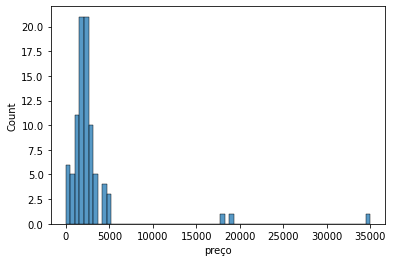

In [30]:
import seaborn as sns
sns.histplot(df.preço)

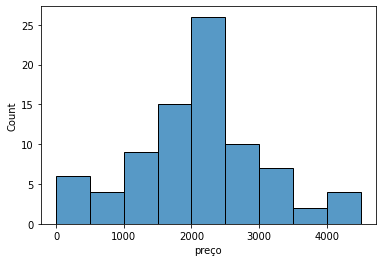

In [31]:
import seaborn as sns
sns.histplot(df[df.preço < np.quantile(df.preço, 0.95)].preço, binwidth=500)